# Estimación de peso y dimensiones de los envíos de Mercado Libre

# Materia: Análisis y Visualización de Datos



In [44]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy
import seaborn
import scipy as sc

In [45]:
random.seed(0)

El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.
Los datos son:[meli_dataset_20190426.csv] (https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v).

In [46]:
DATASET = 'meli_dataset_20190426.csv'

In [47]:
df = pd.read_csv(DATASET, low_memory=False)

In [48]:
df.columns

Index(['ITEM_ID', 'SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT',
       'ATTRIBUTES', 'CATALOG_PRODUCT_ID', 'CONDITION', 'DOMAIN_ID', 'PRICE',
       'SELLER_ID', 'STATUS', 'TITLE'],
      dtype='object')

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [49]:
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
427581,PKHS45PN2N,990.0,25.0,15.0,3.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN
174614,DQTBINORUP,NaN,NaN,NaN,NaN,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BIRD_EGGS_INCUBATORS,399.00,MTVI574CXQ,active,Chocadeira Automática 112 A 120 Ovos + Ovoscópio
195979,A52YA1KYMU,NaN,NaN,NaN,NaN,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-HAIR_SHAMPOOS_AND_CONDITIONERS,49.50,P7409W2WQ3,paused,Óleo Banho Paixão Only You 200ml Kit C/3 Inspi...
211824,L8GGFIBDFY,1065.0,16.0,11.0,6.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",D0CWQ3USI8,new,MLB-AUTOMOTIVE_AMPLIFIERS,649.90,HRPWQ48T51,active,Amplificador Taramps Ds 1200 1200w Rms 4 Canai...
158469,NVQRTW8JTZ,220.0,20.0,20.0,20.0,"[{'id': 'INTERFACE', 'name': 'Interface', 'val...",OZXWQXTTK4,new,MLB-HARD_DRIVES_AND_SSDS,257.89,J44AIDDF3R,active,Hd Externo 1tb Wd Portatil Western Digital Ele...


In [50]:
df = df.dropna(subset=['SHP_WEIGHT'])
df = df.dropna(subset=['SHP_LENGTH'])
df = df.dropna(subset=['SHP_WIDTH'])
df = df.dropna(subset=['SHP_HEIGHT'])
df.sample(3)


,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
166112,SS0ZGFU93Q,169.0,30.0,20.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PRESSURE_GAUGES,170.45,OI54L9XV6H,active,Hallmeter Cronomac 52mm Street Preto - Ar / Co...
232926,D7YHPCTQRQ,50.0,16.0,11.0,2.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-TV_REPLACEMENT_BACKLIGHT_LED_STRIPS,90.00,CZ1QS5Z3UX,paused,Led Lg 3535 6v 2w 32lb5400 39lb5400 42lb5600 5...
442957,FOBX52PRH8,150.0,20.0,11.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN


El objetivo del análisis es predecir el peso y tamaño de los artículos. A su vez el tamaño se puede descomponer en largo, altura y ancho.  Las cuatro variables a predecir son numéricas continuas .
Probablemente la variable explicativa más importante sea DOMAIN_ID y ATTRIBUTES, dado que si se conoce el peso y tamaño de un artículo, los próximos envíos deberían tener las mismas características. En el caso de atributes, hay que preprocesar los datos para poder extraer algo de información.

Luego se dispone de otras variables complementarias, cuya incorporación podría incrementar el poder predictivo del modelo: CONDITION, STATUS, PRICE, SELLER_ID.

En primer lugar es conveniente relizar un análisis descriptivo, principalmente de las variables que se desea predecir.

## Analisis estadístico descriptivo de las variables peso, largo, altura y ancho

In [51]:
df[['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', "SHP_HEIGHT"]].describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT
count,347751.000000,347751.000000,347751.000000,347751.000000
mean,1854.789579,31.451148,21.290276,11.578580
std,3257.884009,18.339895,11.217308,8.310821
min,1.000000,0.000000,0.000000,0.000000
25%,260.000000,20.000000,13.000000,5.000000
50%,675.000000,25.000000,20.000000,10.000000
75%,1900.000000,36.000000,25.000000,16.000000
max,50000.000000,288.200000,165.000000,105.000000


In [52]:
#plt.figure(figsize=(17,5))
#seaborn.jointplot(data=df,
 #                 x='SHP_WEIGHT', y='STATUS', kind='hex')
#seaborn.despine()

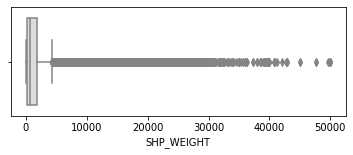

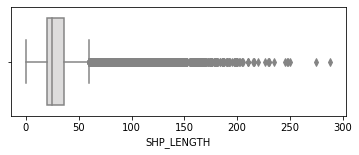

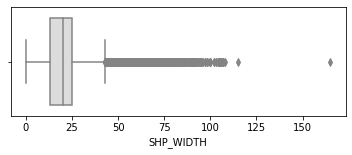

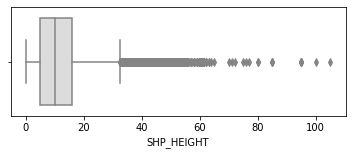

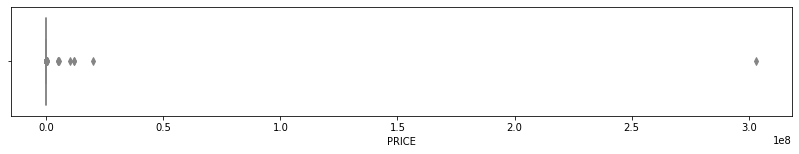

In [53]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_LENGTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WIDTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_HEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(14,2))
seaborn.boxplot(x="PRICE", data=df, palette="coolwarm")

In [54]:
ku = sc.stats.kurtosis(df["SHP_WEIGHT"])
print('Kurtosis de SHP_WEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WEIGHT"])
print('Swewness de SHP_WEIGHT: {}'.format(sw))

Kurtosis de SHP_WEIGHT: 20.399253471252823
Swewness de SHP_WEIGHT: 3.9153529466253163


In [55]:
ku = sc.stats.kurtosis(df["SHP_LENGTH"])
print('Kurtosis de SHP_LENGTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_LENGTH"])
print('Swewness de SHP_LENGTH: {}'.format(sw))

Kurtosis de SHP_LENGTH: 7.986387205669544
Swewness de SHP_LENGTH: 2.210783096690722


In [56]:
ku = sc.stats.kurtosis(df["SHP_WIDTH"])
print('Kurtosis de SHP_WIDTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WIDTH"])
print('Swewness de SHP_WIDTH: {}'.format(sw))

Kurtosis de SHP_WIDTH: 4.010110453831872
Swewness de SHP_WIDTH: 1.4488834173591043


In [57]:
ku = sc.stats.kurtosis(df["SHP_HEIGHT"])
print('Kurtosis de SHP_HEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_HEIGHT"])
print('Swewness de SHP_HEIGHT: {}'.format(sw))

Kurtosis de SHP_HEIGHT: 2.9425875742295364
Swewness de SHP_HEIGHT: 1.4231292439255891


In [58]:
# ku = sc.stats.kurtosis(df["PRICE"])
# print('Kurtosis de PRICE: {}'.format(ku))
# sw = sc.stats.skew(df["PRICE"])
# print('Swewness de PRICE: {}'.format(sw))

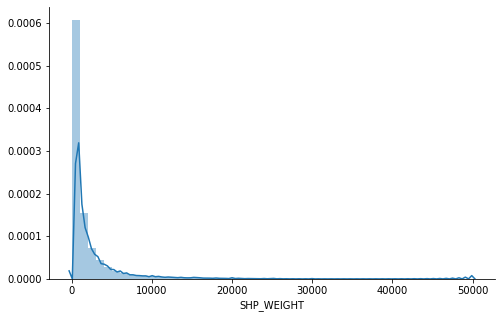

In [59]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_WEIGHT'], label='SHP_WEIGHT')
seaborn.despine()

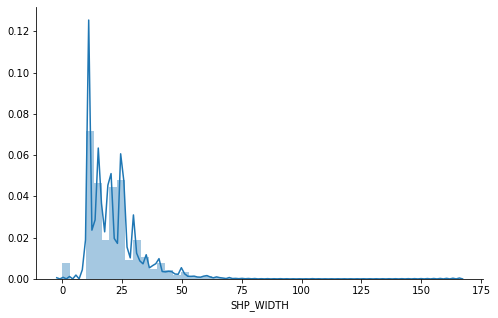

In [60]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_WIDTH'], label='SHP_WIDTH')
seaborn.despine()

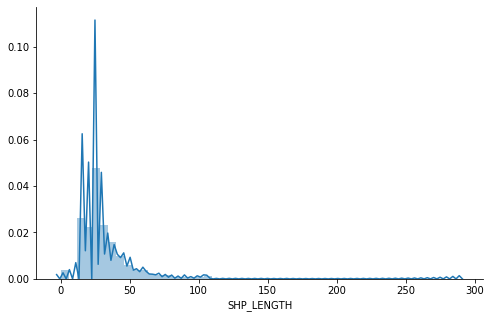

In [61]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_LENGTH'], label='SHP_LENGTH')
seaborn.despine()

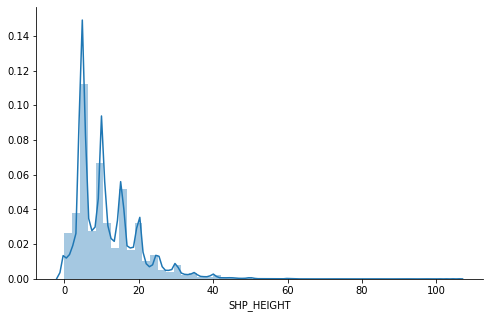

In [62]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_HEIGHT'], label='SHP_HEIGHT')
seaborn.despine()

In [63]:
# plt.figure(figsize=(8,5))
# seaborn.distplot(df['PRICE'], label='PRICE')
# seaborn.despine()

In [64]:
pd.value_counts(df['CONDITION'])

new              260579
used               1023
not_specified       356
Name: CONDITION, dtype: int64

In [65]:
pd.value_counts(df['STATUS'])

active          161502
paused           82196
404              51426
under_review     31159
closed           18442
inactive          3026
Name: STATUS, dtype: int64

In [66]:
pd.value_counts(df['DOMAIN_ID'])

MLB-VEHICLE_ACCESSORIES        6856
MLB-SUPPLEMENTS                5780
MLB-VEHICLE_PARTS              4454
MLB-HAIR_TREATMENTS            3273
MLB-BACKPACKS                  3119
                               ... 
MLB-DOG_COLLARS                   1
MLB-LABEL_MAKER_INK_ROLLERS       1
MLB-PANETTONES                    1
MLB-MODEL_AIRCRAFT_PLANS          1
MLB-AGOGOS                        1
Name: DOMAIN_ID, Length: 2763, dtype: int64

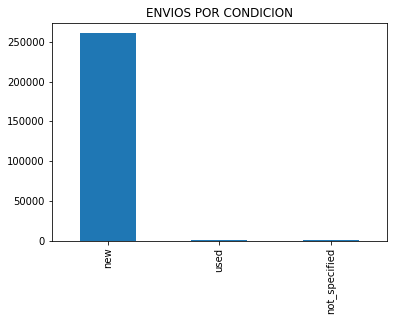

In [67]:
plot = df['CONDITION'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR CONDICION')

En los envíos por condición la categoria modal es nuevo como refleja el gráfico, superando ampliamente las demás categorías

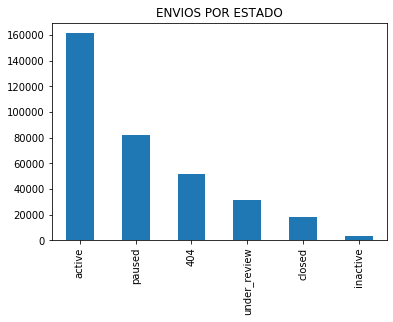

In [68]:
plot = df['STATUS'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR ESTADO')

En los envíos por estado la categoria mas frecuente es activo

## ¿Qué criterios les parece mejor para limpiar el dataset de datos faltantes?

Los datos o el conjunto de datos del que disponemos a menudo no están completos para ser analizados apropiadamente.
La limpieza de los datos consiste en reemplazarlos o eliminarlos de una forma tal que, el resultado final se vea afectado lo menos posible.
Criterios que se podrían considerar para la limpieza:
- Eliminar registros con datos faltantes, eliminado filas con 1 dato faltante, campos nulos que superen una cantidad, o ciertos campos nulos no permitidos
- Reemplazar los valores faltantes con un dato que podría ser, la media, la mediana o la moda de acuerdo al tipo de distribución que tienen los datos
- Comparar los resultados para analizar el impacto considerando ambas alternativas

Para nuestro caso el criterio elegido es eliminar los registros en los que falte alguna de las medidas de peso, precio y volumen.
Vamos a partir de datos completos y los registros que queden fuera del análisis pueden usarse a futuro para determinar Qué valor sería
acorde para completarlos.

## Conclusiones sobre las distribuciones de las variables a predecir


Se aprecia que las cuatro variables a predecir tienen distribuciones con asimetría izquierda bastante marcada, especialmente el peso de los productos. Adempas las cuatro distribuciones son leptocúrticas o sea mas puntiagudas de que la distribución normal. También puede decirse que las variables no tienen distribuciones tan heterogéneas como se podría esperar, pero sí presentan múltiples outliers.

## Categorias/Dominios con mayor homegeneidad y heterogeneidad

In [69]:
df = df.dropna(subset=['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT'])

# df = df.head(10000) #esto no iria, solo tomo 10000 para q no demore tanto

for i, row in df.iterrows():

    #setear en cada registro del data set el coeficiente de variacion de ese peso o medidas en nuevas columnas 
    #CF_SHP_WEIGHT, CF_x, CF_X, CF_X
    
    df.loc[i,'CF_SHP_WEIGHT'] = sc.stats.variation(df.loc[i,'SHP_WEIGHT'])
    df.loc[i,'CF_SHP_LENGTH'] = sc.stats.variation(df.loc[i,'SHP_LENGTH'])
    df.loc[i,'CF_SHP_WIDTH'] = sc.stats.variation(df.loc[i,'SHP_WIDTH'])
    df.loc[i,'CF_SHP_HEIGHT'] = sc.stats.variation(df.loc[i,'SHP_HEIGHT'])
    
#Agrupando ordenando descendente los mejores coeficientes por cada variable de medicion
#Los que tengan valores mas alto son los mas heterogeneos
df_het_cf_shp_weight = df[['DOMAIN_ID', 'CF_SHP_WEIGHT']].sort_values('CF_SHP_WEIGHT', ascending=False)
df_het_cf_shp_length = df[['DOMAIN_ID', 'CF_SHP_LENGTH']].sort_values('CF_SHP_LENGTH', ascending=False)
df_het_cf_shp_width = df[['DOMAIN_ID', 'CF_SHP_WIDTH']].sort_values('CF_SHP_WIDTH', ascending=False)
df_het_cf_shp_height = df[['DOMAIN_ID', 'CF_SHP_HEIGHT']].sort_values('CF_SHP_HEIGHT', ascending=False)

#se armaron listas ordenadas con cada variable y se va a extraer las categorias unicas
print('TOP 20 CATEGORIAS CON SHP_WEIGHT HETEROGENEO')
print(df_het_cf_shp_weight['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_LENGTH HETEROGENEO')
print(df_het_cf_shp_length['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_WIDTH HETEROGENEO')
print(df_het_cf_shp_width['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_HEIGHT HETEROGENEO')
print(df_het_cf_shp_height['DOMAIN_ID'][:20].unique())


#Los que tengan valores mas alto son los mas heterogeneos

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1040: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


TOP 20 CATEGORIAS CON SHP_WEIGHT HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-CARD_PAYMENT_TERMINALS'
 'MLB-MOTORCYCLE_OIL_FILTERS' 'MLB-LAPTOP_KEYBOARDS' nan 'MLB-CUSHIONS'
 'MLB-SHORTS' 'MLB-AUTOMOTIVE_TIRES' 'MLB-AUTOMOTIVE_DEFLECTORS'
 'MLB-HEALTH_CARE_SUPPLIES' 'MLB-CLEANING_MOPS']
TOP 20 CATEGORIAS CON SHP_LENGTH HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-SUNGLASSES' 'MLB-CELLPHONES' nan
 'MLB-COLLECTIBLE_PRODUCTS' 'MLB-SNEAKERS' 'MLB-MOVIES'
 'MLB-MOTORCYCLE_OIL_FILTERS' 'MLB-LAPTOP_KEYBOARDS' 'MLB-CUSHIONS'
 'MLB-CARD_PAYMENT_TERMINALS']
TOP 20 CATEGORIAS CON SHP_WIDTH HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-PAINTINGS' 'MLB-AUTOMOTIVE_EMBLEMS'
 'MLB-AUTOMOTIVE_WHEEL_COVERS' nan 'MLB-MOTORCYCLE_LEVERS'
 'MLB-KITCHEN_SUPPLIES' 'MLB-LIFE_JACKETS' 'MLB-BASS_GUITARS'
 'MLB-TENNIS_BALLS' 'MLB-BOOTS_AND_BOOTIES' 'MLB-SUPPLEMENTS'
 'MLB-WOMEN_SWIMWEAR']
TOP 20 CATEGORIAS CON SHP_HEIGHT HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-PAINTINGS' 'MLB-AUTOMOTIVE_EMBLEMS'
 'MLB-AUTOMOTIVE_WHEE

#### Detección de outliers 

En los diversos boxplots graficados previemente, se puedo determinar que existen outliers dado que hay puntos que exceden a $Q_3 + 1.5 \times RI$. Siguiendo dicho criterio, se encuentran los siguientes outliers en las variables numéricas del dataset.

#### Outliers de SHP_WEIGHT

In [70]:
#df["SHP_WEIGHT"].describe()
#q75, q25 = np.percentile(df["SHP_WEIGHT"], [75,25])
#iqr = q75 - q25
#q1=np.percentile(df["SHP_WEIGHT"], 25)
#q3=np.percentile(df["SHP_WEIGHT"], 75)

q1=df["SHP_WEIGHT"].quantile(0.25)
q3=df["SHP_WEIGHT"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_WEIGHT"][df["SHP_WEIGHT"]>LSO]

50         5800.0
60         6900.0
63         7900.0
130        4684.0
132       14000.0
           ...   
499904    12150.0
499932     8670.0
499933     7190.0
499936    24000.0
499945     4500.0
Name: SHP_WEIGHT, Length: 38163, dtype: float64

#### Outliers de SHP_LENGTH

In [71]:
q1=df["SHP_LENGTH"].quantile(0.25)
q3=df["SHP_LENGTH"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_LENGTH"][df["SHP_LENGTH"]>LSO]

63         97.0
238       102.0
264        94.0
267        63.0
334        68.0
          ...  
499765     88.0
499832     67.0
499844     83.0
499940     71.0
499945     90.0
Name: SHP_LENGTH, Length: 22972, dtype: float64

#### Outliers de SHP_WIDTH

In [72]:
q1=df["SHP_WIDTH"].quantile(0.25)
q3=df["SHP_WIDTH"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_WIDTH"][df["SHP_WIDTH"]>LSO]

44        45.0
63        68.0
171       55.0
264       60.0
267       63.0
          ... 
499715    51.0
499779    45.0
499809    48.0
499850    56.0
499945    50.0
Name: SHP_WIDTH, Length: 16512, dtype: float64

#### Outliers de SHP_HEIGHT

In [73]:
q1=df["SHP_HEIGHT"].quantile(0.25)
q3=df["SHP_HEIGHT"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_HEIGHT"][df["SHP_HEIGHT"]>LSO]

49        33.0
50        37.0
60        40.0
171       44.0
475       33.0
          ... 
499678    35.0
499681    47.0
499779    33.0
499807    38.0
499809    36.0
Name: SHP_HEIGHT, Length: 8769, dtype: float64

In [74]:
#### Outliers de PRICE

In [75]:
# q1=df["PRICE"].quantile(0.25)
# q3=df["PRICE"].quantile(0.75)

# LSO = q3 + 1.5 * (q3-q1)
# df["PRICE"][df["PRICE"]>LSO]